# LibPGM Benchmarking Runtime

Structure learning and CPD estimation algorithms have quite different complexity, this notebook contains routines to generate arbitrary BNs of varying num nodes and node complexity and then perform estimation benchmarking routines on them ...

In [1]:
# Imports
import random,json,copy,pprint,itertools,time
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import libpgm
import libpgm.graphskeleton
from libpgm.graphskeleton import GraphSkeleton
from libpgm.nodedata import NodeData
from libpgm.discretebayesiannetwork import DiscreteBayesianNetwork
from libpgm.pgmlearner import PGMLearner


In [2]:

def is_parent(n,pn,edges):
    n_edges = filter(lambda x: x[0] == n, edges)
    for e in n_edges:
        if e[1] == pn:
            return True
        else:
            if is_parent(e[1],pn,edges):
                return True
    return False

def generate_random_dag(nodes=10):
    nodes = map(lambda x: chr(x), range(65,65+nodes))
    edges = []
    for n in nodes:
        nl = copy.copy(nodes)
        random.shuffle(nl)
        for pn in nl:
            if pn==n:
                continue
            if is_parent(pn,n,edges):
                continue
#            print "new parent edge (%s,%s)"%(n,pn)
            edges.append( [n,pn] )
            break
#        print n
    return nodes,edges


# Plot the learned BN graph
def plot_digraph(nodes,edges):
    
    # Set up the graph 
    G = nx.DiGraph()
    red_edges = edges
    G.add_edges_from(edges)
    labels = dict(zip(nodes,nodes))

    # Plots ...
    plt.figure()
    plt.axis('off')
    pos = nx.spring_layout(G)
    nx.draw_networkx_edges(G, pos, edgelist=red_edges, edge_color='r', arrows=True)
    nx.draw_networkx_nodes(G,pos,nodelist=nodes,node_color='g')
    nx.draw_networkx_labels(G,pos,labels,font_size=16)


def create_discrete_rvs(nodes, mincard=2, maxcard=30):
    word_file = "/usr/share/dict/words"
    words = open(word_file).read().splitlines()
    nodevals = {}
    for n in nodes:
        ncard = np.random.randint(mincard,maxcard)
        nodevals[n] = random.sample(words, ncard)
    return nodevals
        

In [3]:


def generate_random_bn(num_nodes=4, min_card=2, max_card=4):
    V,E = generate_random_dag(num_nodes)
    NV = create_discrete_rvs(V, min_card, max_card)

    graph = {
        "V": V,
        "E": E,
        "Vdata":{}
    }

    for n in V:
        parents = map(lambda x: x[1], filter(lambda x: x[0]==n, E))
        children = map(lambda x: x[0], filter(lambda x: x[1]==n, E))
        parentvals = map(lambda x: NV[x], parents)
        possible_conditions = list(itertools.product(*parentvals))
        noutcomes = len(NV[n])
        if(len(parents)==0):
            parents = None
        if(len(children)==0):
            children = None
        cprob = {}
        if len(possible_conditions) > 1:
            for condition_vals in possible_conditions:
                p = np.random.exponential(size=noutcomes)
                k = str(list(condition_vals))
                cprob[k] = list(p / np.sum(p))
        else:
            p = np.random.exponential(size=noutcomes)
            k = str(list(condition_vals))
            cprob = list(p / np.sum(p))

        nv = {
#        "ord":len(NV[n]),
            "numoutcomes":noutcomes,
            "vals":NV[n],
            "parents":parents,
            "children":children,
            "cprob":cprob
        }
        graph["Vdata"][n] = nv

        
    return graph

def plot_bn(graph):
    plot_digraph(graph['V'],graph['E'])


In [4]:

# Generate a libpgm BN from our model
def gen_discrete_bn(graph):
    skel = GraphSkeleton()
    skel.V = graph['V']
    skel.E = map(lambda x: [x[1],x[0]], graph['E'])
    skel.toporder()
    for i,n in enumerate(skel.V):
        graph["Vdata"][n]["ord"] = i            
    nd = NodeData()
    nd.Vdata = graph['Vdata']
    bn = DiscreteBayesianNetwork(skel, nd)
    return bn

def print_node_cardinalities(graph):
    print "Node Cardinalities..."
    for n in graph["V"]:
        print n,len(graph["Vdata"][n]['vals'])
        

Node Cardinalities...
A 11
B 28
C 15
D 28
E 4
F 8
G 6
H 12
I 14
J 23
K 24
L 13


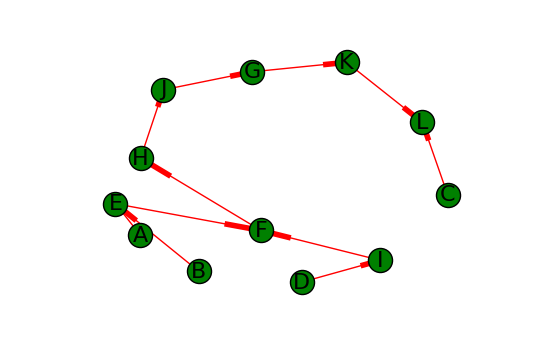

In [5]:
# Generate and Sample from random BN
n_nodes = 12
card_min = 2
card_max = 30

g = generate_random_bn(n_nodes,card_min,card_max)
plot_bn(g)
bn = gen_discrete_bn(g)
samples = bn.randomsample(1024*256, evidence={})
print_node_cardinalities(g)

In [6]:
import openpnl
nodes = []
nodevals = {}
# tabulate nodes and node values from samples
for i in range(0,len(samples)):
    if i == 0:
        for k in samples[i].keys():
            nodes.append(k)
            nodevals[k] = set()
    for k in samples[i].keys():
        nodevals[k].add(samples[i][k])

# Convert sets to lists
for k in nodevals.keys():
    nodevals[k] = list(nodevals[k])
        
print "%d nodes"%(len(nodes))
nodecard = map(lambda x: len(list(nodevals[x])),nodevals.keys())
print "Node Cardinality: " + str(nodecard)
   
###


s1 = [16,32,64,128,256,512,1024,2048,1024*4,1024*8,1024*16,1024*32,1024*64,1024*128,1024*256]
s2 = [16,32,64,128,256,512,1024,2048,1024*4,1024*8,1024*16,1024*32,1024*64,1024*128,1024*256]

learner = PGMLearner()

def mk_n_ev(n):
    # Convert evidence trace to a 2D matrix
    ev = np.zeros([n, len(nodes)], dtype='int32')
    for i in range(0,n):
        for j,k in enumerate(samples[i].keys()):
            ev[i,j] = nodevals[k].index(samples[i][k])                
    return ev

# Time the structure learning ...
structure_runtimes = []
cpd_runtimes = []
for s in s1:
    bn = openpnl.mkSkelBNet(nodecard)
    sl = openpnl.mkCMlStaticStructLearnHC(bn)
    sl.SetPyData(bn, mk_n_ev(s))
    t1 = time.time()
    sl.Learn()
    t2 = time.time()        
    structure_runtimes.append( t2-t1 )
    print "structure", s, t2-t1
    
for s in s2:
    pl = openpnl.CEMLearningEngine.Create(bn)
    pl.SetPyData(bn, mk_n_ev(s))
    t1 = time.time()
    pl.Learn()
    t2 = time.time()    
    cpd_runtimes.append( t2-t1 )
    print "cpd est", s, t2-t1
    


12 nodes
Node Cardinality: [11, 15, 28, 4, 28, 6, 8, 14, 12, 24, 23, 13]
structure 16 0.00439500808716
structure 32 0.00500702857971
structure 64 0.00690817832947
structure 128 0.00949597358704
structure 256 0.0170311927795
structure 512 0.0263941287994
structure 1024 0.0593469142914
structure 2048 0.140180826187
structure 4096 0.329294919968
structure 8192 0.665757894516
structure 16384 1.40758609772
structure 32768 3.11030387878
structure 65536 6.46901392937
structure 131072 11.2487168312
structure 262144 24.7105829716
cpd est 16 5.79357147217e-05
cpd est 32 6.29425048828e-05
cpd est 64 0.000108957290649
cpd est 128 0.000200986862183
cpd est 256 0.000384092330933
cpd est 512 0.000870943069458
cpd est 1024 0.00153207778931
cpd est 2048 0.00290203094482
cpd est 4096 0.00632309913635
cpd est 8192 0.0132191181183
cpd est 16384 0.0287170410156
cpd est 32768 0.0648679733276
cpd est 65536 0.137164115906
cpd est 131072 0.276700019836
cpd est 262144 0.548815965652


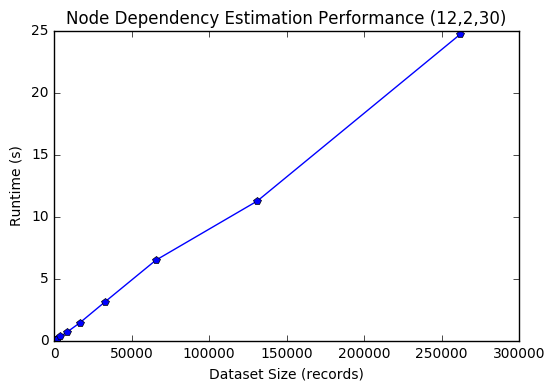

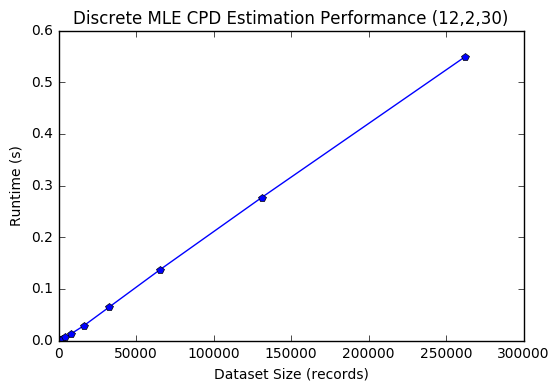

In [7]:
plt.figure()
plt.plot(s1, structure_runtimes,'p-')
plt.xlabel("Dataset Size (records)")
plt.ylabel("Runtime (s)")
plt.title("Node Dependency Estimation Performance (%d,%d,%d)"%(n_nodes,card_min,card_max))
plt.figure()
plt.plot(s2, cpd_runtimes,'p-')
plt.xlabel("Dataset Size (records)")
plt.ylabel("Runtime (s)")
plt.title("Discrete MLE CPD Estimation Performance (%d,%d,%d)"%(n_nodes,card_min,card_max))

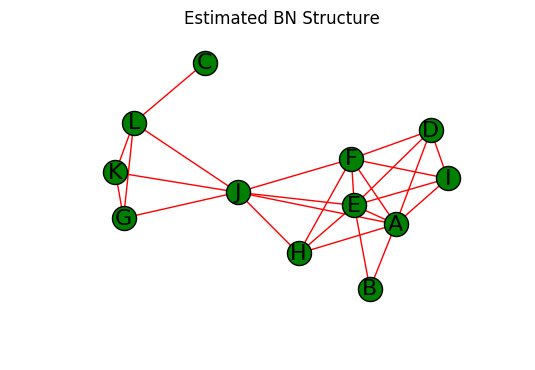

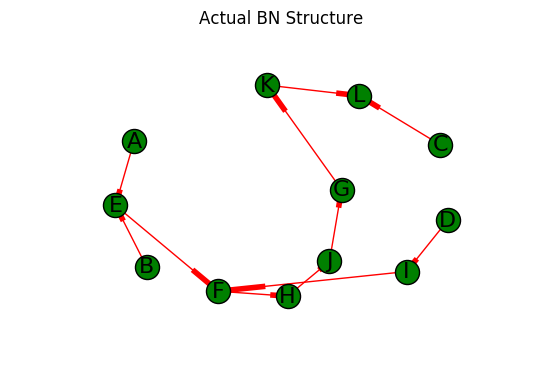

In [8]:
dag = sl.GetResultDAG();
am = dag.adjMatrix(len(nodes)**2).reshape([len(nodes),len(nodes)])

# Plot the learned BN graph
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


# Set up the graph 
G = nx.from_numpy_matrix(am)
red_edges = G.edges()
values = range(0,len(nodes))
labels = dict(zip(values,nodes))

# Plots ...
plt.figure()
plt.axis('off')
pos = nx.spring_layout(G)
nx.draw_networkx_edges(G, pos, edgelist=red_edges, edge_color='r', arrows=True)
nx.draw_networkx_nodes(G,pos,nodelist=values,node_color='g')
nx.draw_networkx_labels(G,pos,labels,font_size=16)
plt.title("Estimated BN Structure")

plot_bn(g)
plt.title("Actual BN Structure")